# Efficient LLM Training Tutorial

<a target="_blank" href="https://colab.research.google.com/github/MENA-ML/tutorials2025-solutions/blob/main/efficient_llm_training/LLM_Finetuning_Solution.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


This is the tutorial for the **2025 Middle East and North Africa Machine Learning (MenaML) Winter School**!

This tutorial will explore the fundamental aspects of Finetuning Large Language Models for specific tasks or domains. Basic Python programming skills are expected. Prior knowledge of standard LLM components (e.g. transformers, autoregression) is beneficial but optional when working through the notebooks as they assume minimal prior knowledge.

This tutorial combines detailed analysis and development of essential LLM Finetuning concepts via a practical exercise. Other necessary components will be developed using PyTorch. As a result, the tutorial offers deep understanding and facilitates easy usage in future applications.

# Notation
Sections marked with [📚] contain cells that you should read, modify and complete to understand how your changes alter the obtained results.
External resources are mentioned with [✨]. These provide valuable supplementary information for this tutorial and offer opportunities for further in-depth exploration of the topics covered.

# Libraries
This tutorial leverages PyTorch for transformer implementation and training, complemented by standard Python libraries for data processing and the Hugging Face datasets and transformer library.


# Hardware

GPU access is recommended for optimal performance, particularly for model training and text generation. CUDA-enabled environment will significantly speed up these processes. Please connect to the free colab runtime with **T4 GPU** runtime type.

# Credits
The tutorial is created by:

[Pranali Yawalkar](https://www.linkedin.com/in/pranali-yawalkar/)

It is inspired by and synthesizes various online resources, which are cited throughout for reference and further reading.

# Prerequisites

Verified account on http://huggingface.co

# Step 1. Basic

In [ ]:
import os

os.environ["WANDB_DISABLED"] = "true"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Step 2. Install Dependencies

In [ ]:
!pip3 install -q -U bitsandbytes==0.45.2
!pip3 install -q -U peft==0.8.2
!pip3 install -q -U trl==0.7.10
!pip3 install -q -U accelerate==0.27.1
!pip3 install -q -U datasets==2.17.0
!pip3 install -q -U transformers==4.45.2
!pip3 install -q -U trl==0.11.2

# 📚 Step 3. Load GPT-2 Model

## [Optional] Model Architecture

For this tutorial, we'll be working with **GPT-2 pretrained** model.



1.   Decoder only model
2.   Trained on context length of 1024 tokens
3.   This is the smallest version of GPT-2, with **124M** parameters  


In [ ]:
# @title 📚  Load Model

import gc
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer


def reload_model():
  m = AutoModelForCausalLM.from_pretrained("openai-community/gpt2").to("cuda:0")
  return m


global TOKENIZER, MODEL
TOKENIZER = AutoTokenizer.from_pretrained("openai-community/gpt2")
if TOKENIZER.pad_token is None:
  TOKENIZER.pad_token = TOKENIZER.eos_token
MODEL = reload_model()

In [ ]:
# @title Inferences


def query_model(model, query: str, max_tokens: int = 64) -> str:
  # EXERCISE 1. Read PyTorch based documentation at
  # https://huggingface.co/docs/transformers/en/main_classes/text_generation
  # and complete this function

  # Please add `pad_token_id=TOKENIZER.eos_token_id` to the generate args
  # for masking attention on padded tokens.
  device = 'cuda:0'
  inputs = TOKENIZER(query, return_tensors='pt').to(device)

  outputs = model.generate(
      **inputs,
      max_new_tokens=max_tokens,
      pad_token_id=TOKENIZER.eos_token_id,
  )
  return TOKENIZER.decode(outputs[0], skip_special_tokens=True)

In [ ]:
# @title Sample Query


def sample_query(
    query: str = (
        'Give me a bulleted list of the 5 highest mountains in the world and'
        ' their respective heights in meters'
    ),
):
  print('Query: ', query)
  print('Response: ', query_model(MODEL, query))


sample_query()

In [ ]:
print(TOKENIZER.pad_token)
print(TOKENIZER.eos_token)

# Step 4. LLM Training Fundamentals



## Finetuning Introduction

We will be finetuning the GPT-2 model with Dolly 15k dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for instruction tuning LLMs. The data cover brainstorming, classification, closed QA, generation, information extraction, open QA and summarization type of tasks.

## Finetuning Training Workflow

A typical training workflow looks like:

1. Identify the task you want to make the LLM better at 🧑
2. Create evaluation data and framework that we want the LLM to get better at ❗
3. Pick/ create datasets aka ground truth that truly represent the task 📚
4. Data mixture recipes 📚:
        *   Packing
        *   Optional padding
        *   Optional truncation
        *   Shuffling
        *   Batching
        *   Repeating
        *   Weighted mixtures

5. Training loop with various hyperparameters ➰:
        *   Num epochs
        *   Batch size
        *   Learning Rate
        *   Optimizer -- rarely changed
        *   Warm up steps, learning schedule
6. Validation set for picking the best checkpoint ✅
7. Rerun evaluations ❗
8. Save the new checkpoint 💾


# 📚 Step 5. Load Dolly15k data for Training and Evals

In [ ]:
from datasets import Dataset
from datasets import load_dataset

# EXERCISE 2: load the `databricks-dolly-15k` dataset of `main` revision using
# `load_dataset`
# ✨ Documentation at https://huggingface.co/docs/datasets/en/loading

ds = load_dataset(
    'databricks/databricks-dolly-15k',
    'default',
    cache_dir='/tmp',
    keep_in_memory=True,
)

# EXERCISE 3: Create the `train` and `test` splits of this dataset and print
# their lengths.
# Split 14000 entries into `ds_train`, 1k into `ds_test`, and sample 10 from the
# `test` into another smaller set `small_ds_test` for eyeballing.

ds_train = ds['train'].select(range(14000))
ds_test = ds['train'].select(range(14000, len(ds['train'])))
small_ds_test = ds_test.select(range(10))
print(len(ds_train), len(ds_test), len(small_ds_test))

Generating train split: 0 examples [00:00, ? examples/s]

14000 1011 10


In [ ]:
###
# EXERCISE 4: Format entries of train example to follow a pattern like
#
# "Query: ..."
# "Response: ..."
# EOS
#
# ✨ Documentation: https://huggingface.co/docs/trl/en/sft_trainer
# ✨ EOS documentation: https://www.natebrake.com/blog/llm/end-of-sequence-explained
# As a fun exercise, try finetuning without EOS!
###


def train_formatting_func(element) -> dict[str]:
  # Return {"text": formatted_element}. We use the "text" key while training.
  return {
      "text": (
          f"Query: {element['instruction']}\nResponse:"
          f" {element['response']}{TOKENIZER.eos_token}"
      )
  }


ds_train = ds_train.map(train_formatting_func)


###
# EXERCISE 5: Format entries of test example to follow a pattern like
#
# "Query: ..."
# "Response:"
###
def test_formatting_func(element) -> dict[str]:
  # Return {"text": formatted_element}. We use the "text" key while evaluating.
  return {"text": f"Query: {element['instruction']}\nResponse:"}


small_ds_test = small_ds_test.map(test_formatting_func)

print(ds_train[0])
print(small_ds_test[0])

Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

{'instruction': 'When did Virgin Australia start operating?', 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.", 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.', 'category': 'closed_qa', 'text': 'Query: When did Virgin Australia start operating?\nResponse: Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.<|endoftext|>'}
{'instruction': 'What is the main cause of lightning?', 'context': '', 're

# 📚 Step 6. Evals

In [ ]:
for i in range(len(small_ds_test)):
  query = small_ds_test['instruction'][i]
  predicted_output = query_model(MODEL, query, max_tokens=64)
  actual_output = small_ds_test['response'][i]
  print(i)
  print('True response')
  print(actual_output)
  print('--------------')
  print('Predicted response')
  print(predicted_output)
  print("****************")

0
Lightning happens when the negative charges (electrons) in the bottom of the cloud are attracted to the positive charges (protons) in the ground.
--------------
What is the main cause of lightning?

When a lightning bolt strikes a person or thing, it releases forceps that have a natural tendency to tear apart, destroy and break apart the skin. The shock creates a thick layer of cold, wet or cold debris that can cause serious injury, especially during a lightning strike.

How is lightning formed?
****************
1
• 1978 - the launch of the sculptural program that included the construction of seven contemporary fountains in Paris
• 1937 - fountains of the Palais de Chaillot were built
• 1971 - the date that Les Halles was torn down
--------------
Extract all of the dates mentioned in this paragraph and list them using bullets in the format {Date} - {Description} - and use them as bullets. When you are ready to use the first bullet, use an arrow to put it into the original case, and a

# 📚 Step 7. Prepare Train Utils

In [ ]:
# @title Plot Loss Curves (Purely orchestration code)

import matplotlib.pyplot as plt
import numpy as np
from transformers import TrainerCallback


class LossCallback(TrainerCallback):

  def __init__(
      self,
  ):
    self.loss_history = []

  def on_log(self, args, state, control, logs=None, **kwargs):
    if state.is_local_process_zero and logs:
      if 'loss' in logs:
        self.loss_history.append(logs['loss'])


# Function to plot the loss curve
def plot_loss_curve(losses, smoothing=0.1):
  # Create steps for x-axis
  steps = np.arange(10, (len(losses) + 1) * 10, step=10)

  # Calculate smoothed losses for better visualization
  if smoothing > 0:
    smoothed_losses = []
    for i in range(len(losses)):
      if i == 0:
        smoothed_losses.append(losses[i])
      else:
        smoothed_loss = (
            smoothing * losses[i] + (1 - smoothing) * smoothed_losses[-1]
        )
        smoothed_losses.append(smoothed_loss)
  else:
    smoothed_losses = losses

  # Create the plot
  plt.figure(figsize=(5, 3))
  plt.plot(steps, losses, label='Raw Loss', alpha=0.3)
  # plt.plot(steps, smoothed_losses, label='Smoothed Loss', linewidth=2)

  # Customize the plot
  plt.xlabel('Training Steps')
  plt.ylabel('Loss')
  plt.title('Training Loss Curve')
  plt.grid(True, linestyle='--', alpha=0.7)
  plt.legend()

  # Show the plot
  plt.show()

In [ ]:
from peft import LoraConfig
import transformers
from transformers import Trainer, TrainingArguments
from trl import DataCollatorForCompletionOnlyLM, SFTConfig, SFTTrainer


def train(
    *,
    learning_rate: float,
    model: transformers.PreTrainedModel = MODEL,
    num_epochs: int = 1,
    dataset: Dataset = ds_train,
    lora_config: LoraConfig = None,
    max_steps: int = -1,
):
  # EXERCISE 6: Create SFTConfig by reading
  # ✨ https://huggingface.co/docs/trl/v0.14.0/en/sft_trainer#trl.SFTConfig
  # with the above epochs, learning rate. Other constant hypers are:
  # ✨`paged_adamw_8bit` optimizer
  # 5% warmup ratio
  # "cosine" lr schedule
  # fp16 True
  # log loss every 10 steps
  # dataset_text_field to 'text'

  # Github if needed: https://github.com/huggingface/trl/blob/main/trl/trainer/sft_config.py
  # https://github.com/huggingface/transformers/blob/main/src/transformers/training_args.py

  # EXERCISE 7: What's the best strategy to set the batch size?

  # EXERCISE 8: What's the best strategy to set packing to?
  args = SFTConfig(
      auto_find_batch_size=True,
      learning_rate=learning_rate,
      warmup_ratio=0.05,
      lr_scheduler_type="cosine",
      output_dir="outputs",
      optim="paged_adamw_8bit",
      fp16=True,
      num_train_epochs=num_epochs,
      logging_steps=10,
      dataset_text_field="text",
      packing=True,
      per_device_train_batch_size=16,
      max_steps=max_steps,
  )

  # Updates model in place
  trainer = SFTTrainer(
      model=model,
      train_dataset=dataset,
      args=args,
      peft_config=lora_config,
  )
  callback = LossCallback()
  trainer.add_callback(callback)

  trainer.train()
  plot_loss_curve(callback.loss_history)
  return trainer

# 📚  Step 8. Finetune!

## Libraries

✨ https://huggingface.co/docs/trl/en/sft_trainer

## 📚  Train

LR:  0.05


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1080 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


Step,Training Loss
10,72.617800
20,232.432300
30,143.359000
40,0.000000
50,0.000000


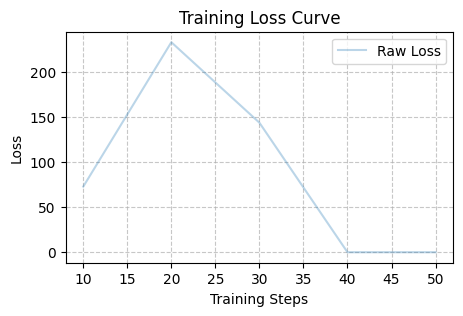

LR:  0.005


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


Step,Training Loss
10,7.777800
20,7.602900
30,6.626000
40,6.307800
50,6.127900


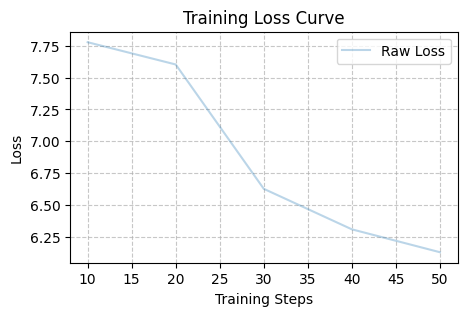

LR:  0.0005


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


Step,Training Loss
10,3.468700
20,3.132200
30,3.043100
40,3.036600
50,2.968300


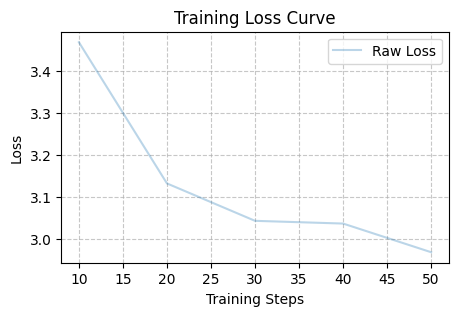

LR:  5e-05


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


Step,Training Loss
10,3.515300
20,3.156100
30,3.049300
40,3.059600
50,2.994500


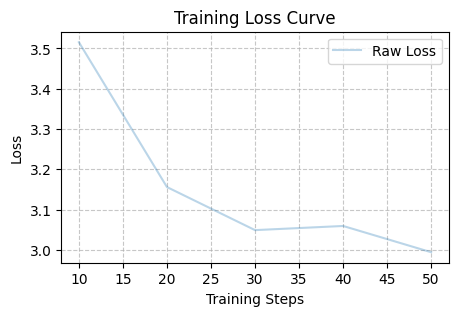

LR:  5e-06


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You passed `packing=True` to the SFTTrainer/SFTConfig, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


Step,Training Loss
10,3.604200
20,3.485400
30,3.371200
40,3.365400


Step,Training Loss
10,3.324700
20,3.271900
30,3.242600
40,3.212900
50,3.222900


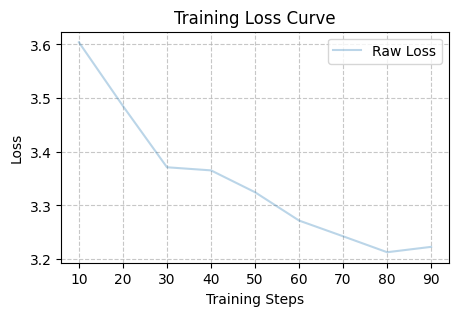

In [ ]:
# @title Learning Rate Sweep

# EXERCISE 9: sweep over learning rates in the set
# [5e-2, 5e-3, 5e-4, 5e-5, 5e-6] to find the best
# one that minimises the training loss and does not overfit. Consider
# running for a small fixed number of steps like 50.
# A good learning rate should allow:

# Gradual loss reduction
# Sufficient exploration of the loss landscape to avoid local minimas
# Time for the model to learn meaningful patterns
# Balance between convergence speed and generalization

for lr in [5e-2, 5e-3, 5e-4, 5e-5, 5e-6]:
  print('LR: ', lr)
  temp_model = reload_model()
  trainer = train(model=temp_model, learning_rate=lr, max_steps=50)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss
10,3.482900
20,3.107100
30,3.040800
40,3.061900
50,3.031000
60,3.042500
70,3.033200
80,3.015700
90,2.979600
100,2.984300


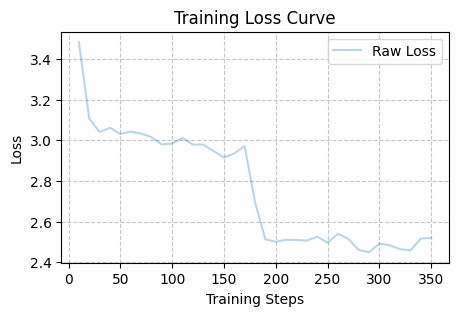

16


In [ ]:
# @title Run Full Finetuning

MODEL = reload_model()

# EXERCISE 10: Run the full train run for 2 epochs using the learning_rate
# chosen above

trainer = train(model=MODEL, learning_rate=5e-4, num_epochs=1)

# EXERCISE 11: Identify what batch size was used for training
# from this https://huggingface.co/transformers/v3.0.2/main_classes/trainer.html
print(trainer.args.train_batch_size)

# Step 9. Run Evals for Finetuned Model

In [ ]:
def run_ft_evals():
  for i in range(len(small_ds_test)):
    # EXERCISE 12: Rewrite the query and parse the output correctly to adhere to
    # the formatting constraints from step 5.
    formatted_query = small_ds_test['text'][i]
    output = query_model(MODEL, formatted_query, max_tokens=64)
    predicted_output = output.split("Response: ")[1]

    actual_output = small_ds_test['response'][i]
    print(i)
    print('True response')
    print(actual_output)
    print('--------------')
    print('Predicted response')
    print(predicted_output)
    print("****************")


run_ft_evals()

0
Lightning happens when the negative charges (electrons) in the bottom of the cloud are attracted to the positive charges (protons) in the ground.
--------------
In the United States, there is a single primary cause that explains lightning damage: electrical current itself (for example a circuit). The majority of the lightning that strikes the wiring of an AC power outlet is from a conductor that can be placed near a dead wire that the circuit passes through, so the current has to travel through
****************
1
• 1978 - the launch of the sculptural program that included the construction of seven contemporary fountains in Paris
• 1937 - fountains of the Palais de Chaillot were built
• 1971 - the date that Les Halles was torn down
--------------
[date}

-{Description} - {Description} - {Description}
-{Description} - {Description}
-{Description} - {Description} - {Description}
-{Description} - {Description}
-{Description} - {Description} [
-{Description} -
****************
2
foot is i

# Step 10. LoRA Finetune!

## Identify Trainable Params

These parameters are learnable parameters and are updated during training such that the predictive power of the model increases.


1.   **Weights**: Measure the importance of each input or feature in predicting

2.   **Biases**: A constant term added to the sum of weighted inputs
the output



In [ ]:
def print_trainable_parameters(model):
  """Prints the number of trainable parameters in the model."""
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} ||"
      f" trainable: {100 * trainable_params / all_param:.2f}%"
  )

In [ ]:
print_trainable_parameters(MODEL)

trainable params: 124439808 || all params: 124439808 || trainable: 100.00%


## LoRA Concepts

![](https://drive.google.com/uc?export=view&id=1534a4LeyfTSegnm4Dnfxx6_mWB0BMUOZ)


1. **Efficient Parameter Adjustment**: Instead of modifying all the original model's parameters (which are numerous and resource-intensive), LoRA introduces trainable rank decomposition matrices into each layer of the Transformer architecture. These matrices have a much smaller size than the original model's weight matrices.

![](https://drive.google.com/uc?export=view&id=1Kz68zGJ_9IuZWQ-0tcGaD-Azm5G4GDCW)


2. **Reduced Memory Footprint**: By training only these smaller matrices, LoRA significantly reduces the memory requirements associated with fine-tuning large models.


3. **Avoids Catastrophic Forgetting**: The original model's weights remain frozen, and the LoRA matrices capture the task-specific knowledge, allowing the model to adapt to new data or tasks without altering its core capabilities.


4. **Merging with the Original Model**: During inference, the low-rank matrices are merged back with the original weights, effectively injecting the learned knowledge into the model.


5. **Modularity and Reusability**: The trained LoRA modules can be easily swapped, enabling flexible and efficient adaptation across various tasks.


**LoRA has been shown to achieve comparable or even better performance than full fine-tuning, while using significantly fewer resources.**


## Libraries

*   ✨ https://huggingface.co/docs/trl/en/sft_trainer
*   ✨ https://huggingface.co/docs/peft/en/package_reference/lora

## LoRA Hypers

✨ [LoRA Hypers doc](https://medium.com/@fartypantsham/what-rank-r-and-alpha-to-use-in-lora-in-llm-1b4f025fd133)

![](https://drive.google.com/uc?export=view&id=1eGxjTrnkpHxM8VN_SKJLa6yff0gmxJYP)



1.   **r**: rank of the LoRA matrices that capture information about our task. Higher the better. Typically, **low ranks: 8, 16, 32** and **high ranks: 128, 256**
2.   **lora_alpha**: Alpha is a scaling factor -- it changes how the LoRA's weights are weighed against the base model's. Higher alpha means the LoRA layers act more strongly than the base model. Typically set to **r** or **2 x r**. The original LoRA method uses the scalar function **lora_alpha/r** for scaling LoRA weights during forward pass.

## 📚 Train

r:  32  lora_alpha:  32


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You

Step,Training Loss


Step,Training Loss
10,3.378700
20,3.135600
30,3.079100
40,3.039100
50,3.050300


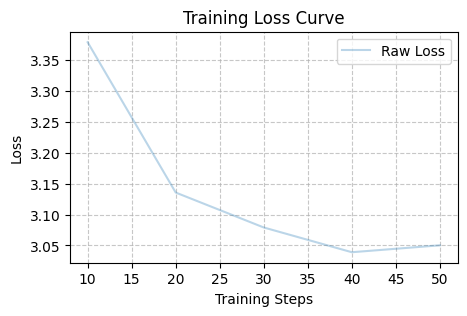

trainable params: 1179648 || all params: 125619456 || trainable: 0.94%
None
r:  32  lora_alpha:  64


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You

Step,Training Loss
10,3.370800
20,3.123500
30,3.047000
40,3.056600
50,2.987800


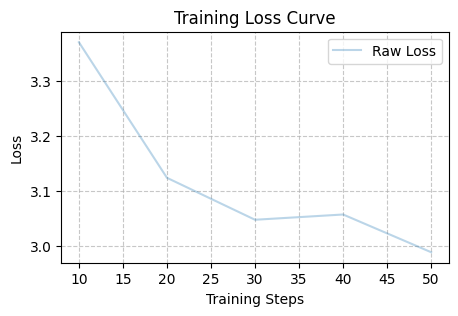

trainable params: 1179648 || all params: 125619456 || trainable: 0.94%
None
r:  64  lora_alpha:  64


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You

Step,Training Loss


Step,Training Loss
10,3.370100
20,3.149000
30,3.090800
40,3.043800
50,3.045700


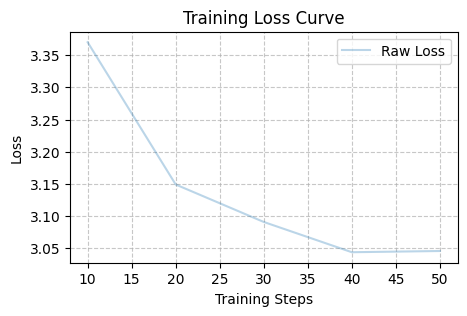

trainable params: 2359296 || all params: 126799104 || trainable: 1.86%
None
r:  64  lora_alpha:  128


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You

Step,Training Loss
10,3.387600
20,3.143600
30,3.063400
40,3.065300
50,2.993900


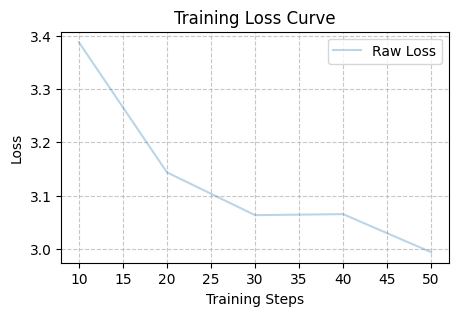

trainable params: 2359296 || all params: 126799104 || trainable: 1.86%
None
r:  128  lora_alpha:  128


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You

Step,Training Loss


Step,Training Loss
10,3.393000
20,3.190700
30,3.120300
40,3.064100
50,3.061200


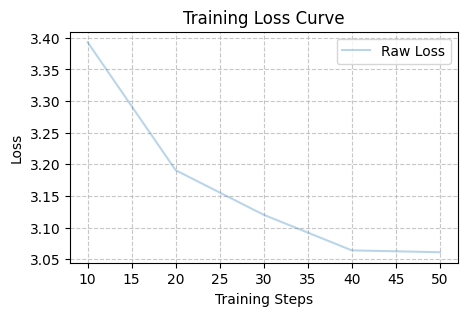

trainable params: 4718592 || all params: 129158400 || trainable: 3.65%
None
r:  128  lora_alpha:  256


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:421: UserWarning: You

Step,Training Loss
10,3.503400
20,3.237700
30,3.119100
40,3.101400
50,3.022800


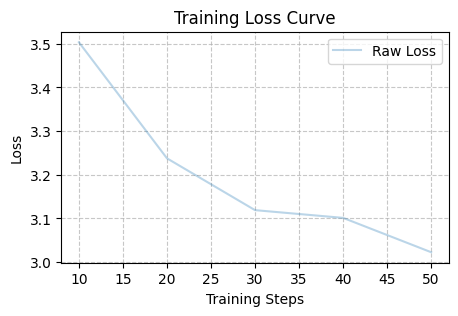

trainable params: 4718592 || all params: 129158400 || trainable: 3.65%
None


In [ ]:
# @title LoRA Hyper Sweep

# EXERCISE 13: sweep over r in the set [32, 64, 128] and lora_alpha over
# [r, 2xr] to find the best values that give the least training loss.
# Consider running for a small fixed number of steps like 50.

# EXERCISE 14: For every sweep, also print the trainable params for the
# finetuned model.

# Set learning_rate to one order of magnitude higher than full finetuning
# as LoRA typically needs a higher LR for the reduced set of trainable params.

from peft import LoraConfig

base_lora_config = LoraConfig(
    lora_dropout=0.01,
    bias='none',
    task_type='CAUSAL_LM',
)

for r in [32, 64, 128]:
  for lora_alpha in [r, 2 * r]:
    print('r: ', r, ' lora_alpha: ', lora_alpha)
    base_config_dict = base_lora_config.to_dict()
    base_config_dict['r'] = r
    base_config_dict['lora_alpha'] = lora_alpha

    lora_config = LoraConfig(**base_config_dict)
    temp_model = reload_model()
    train(
        model=temp_model,
        lora_config=lora_config,
        max_steps=50,
        learning_rate=5e-3,
    )
    print(print_trainable_parameters(temp_model))

In [ ]:
# Fill these values with the chosen hypers
LORA_LEARNING_RATE = 5e-3
LORA_R = 32
LORA_ALPHA = 64

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss
10,3.464200
20,3.142000
30,3.068300
40,3.069500
50,2.991800
60,3.004200
70,3.009200
80,2.984500
90,2.951200


Step,Training Loss
10,2.921900
20,2.960200
30,2.946700
40,2.967600
50,3.006800
60,2.982800
70,3.064600
80,3.056800
90,3.127800
100,2.962800


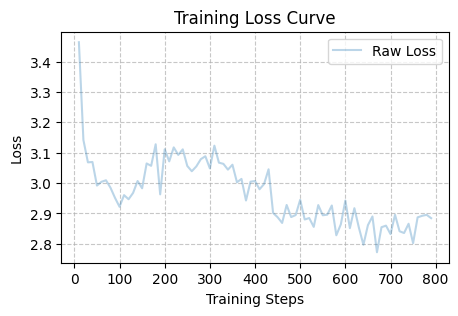

trainable params: 1179648 || all params: 125619456 || trainable: 0.94%
None


In [ ]:
# @title Run LoRA.

# EXERCISE 15: Run for 2 epochs using the hypers tuned above.
# Remember to use LORA_LEARNING_RATE

base_lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=0.01,
    bias="none",
    task_type="CAUSAL_LM",
)

MODEL = reload_model()
trainer = train(
    model=MODEL,
    lora_config=base_lora_config,
    learning_rate=LORA_LEARNING_RATE,
    num_epochs=2,
)
print(print_trainable_parameters(MODEL))

## Eval

In [ ]:
run_ft_evals()

0
Lightning happens when the negative charges (electrons) in the bottom of the cloud are attracted to the positive charges (protons) in the ground.
--------------
When an object comes into contact with a lightning, the lightning strikes on the ground. Like an ordinary lightning strike, lightning strike is caused by a ground ground reaction of the earth. The ground is the center of earth and the path of the lightning is from there. The lightning strikes from the Earth in the Earth's center
****************
1
• 1978 - the launch of the sculptural program that included the construction of seven contemporary fountains in Paris
• 1937 - fountains of the Palais de Chaillot were built
• 1971 - the date that Les Halles was torn down
--------------
{Description} - {Description} - {Description} - {Description}
****************
2
foot is imperial, metre is metric
--------------
Feet: metric
Minimetres: imperial
Perimeter: imperial
GPS: 2.2 meters
****************
3
Asperger syndrome (AS), or Aspe

# 📚  [Advanced] Step 11. Custom PEFT

## Libraries



1.   [SFTTrainer](https://github.com/huggingface/trl/blob/main/trl/trainer/sft_trainer.py)
2.   [PEFT](https://github.com/huggingface/peft)
3.   [Transformers](https://github.com/huggingface/transformers)
4. [PyTorch NN](https://pytorch.org/docs/stable/nn.html)


## 📚  Create Custom LoRA

In [ ]:
from peft.tuners.lora.layer import Linear
import torch.nn as nn


class CustomLinearLoRA(Linear):
  # This code works for linear layers LoRA such as attention layer.
  def update_layer(
      self,
      adapter_name,
      r,
      lora_alpha,
      lora_dropout,
      init_lora_weights,
      use_rslora=False,
      use_dora=False,
  ):
    if r <= 0:
      raise ValueError(
          f"`r` should be a positive integer value but the value passed is {r}"
      )

    self.r[adapter_name] = r
    self.lora_alpha[adapter_name] = lora_alpha

    # EXERCISE 16: Define a dropout layer
    lora_dropout_layer = (
        nn.Dropout(p=lora_dropout) if lora_dropout > 0.0 else nn.Identity()
    )

    self.lora_dropout.update(nn.ModuleDict({adapter_name: lora_dropout_layer}))

    # Actual trainable parameters
    # EXERCISE 17: write a linear layer that goes from self.in_features to r
    self.lora_A[adapter_name] = nn.Linear(self.in_features, r, bias=False)
    # EXERCISE 18: write a linear layer that goes from r to self.out_features
    self.lora_B[adapter_name] = nn.Linear(r, self.out_features, bias=False)

    self.scaling[adapter_name] = lora_alpha / r

    self.reset_lora_parameters(adapter_name, init_lora_weights)
    self.set_adapter(self.active_adapter)

  def forward(self, x, *args, **kwargs):
    result = self.base_layer(x, *args, **kwargs)
    torch_result_dtype = result.dtype

    if self.active_adapter not in self.lora_A.keys():
      return result
    lora_A = self.lora_A[self.active_adapter]
    lora_B = self.lora_B[self.active_adapter]
    dropout = self.lora_dropout[self.active_adapter]
    scaling = self.scaling[self.active_adapter]

    x = x.to(lora_A.weight.dtype)

    x = dropout(x)

    # EXERCISE 19: add to the result of the base layer, the output of
    # lora_B and lora_A and multiply by the scaling factor
    result = result + lora_B(lora_A(x)) * scaling

    result = result.to(torch_result_dtype)

    return result

## Hooking PeFT Model with Huggingface [Purely orchestration code]

Since we are using the HuggingFace PEFT library framework, we need to tweak some of its internal workings to be able to expose the LoRA layer above. Therefore the following cell is not very insightful to understand during this tutorial.

In [ ]:
from peft import LoraConfig, LoraModel, PeftModel, get_peft_model
from peft.tuners.lora.layer import Linear, dispatch_default
from peft.tuners.tuners_utils import BaseTunerLayer
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer
from transformers.utils import PushToHubMixin


def custom_dispatch_default(
    target: torch.nn.Module, adapter_name, lora_config, **kwargs
):
  new_module = None
  target_base_layer = (
      target.get_base_layer() if isinstance(target, BaseTunerLayer) else target
  )

  if isinstance(target_base_layer, torch.nn.Linear):
    kwargs.update(lora_config.loftq_config)
    new_module = CustomLinearLoRA(target, adapter_name, **kwargs)

  if new_module is None:
    new_module = dispatch_default(
        target, adapter_name, lora_config=lora_config, **kwargs
    )
  return new_module


class CustomLoraModel(LoraModel):

  @staticmethod
  def _create_new_module(lora_config, adapter_name, target, **kwargs):
    return custom_dispatch_default(
        target, adapter_name, lora_config=lora_config, **kwargs
    )


class CustomPeftModel(PeftModel):

  def __init__(self, model, peft_config, adapter_name="default"):
    PushToHubMixin.__init__(self)
    torch.nn.Module.__init__(self)

    self.modules_to_save = None
    self.active_adapter = adapter_name
    self.peft_type = peft_config.peft_type
    # These args are special PEFT arguments that users can pass.
    # They need to be removed before passing them to forward.
    self.special_peft_forward_args = {"adapter_names"}

    self._is_prompt_learning = peft_config.is_prompt_learning
    self._peft_config = None
    self.base_model = CustomLoraModel(
        model, {adapter_name: peft_config}, adapter_name
    )

    self.set_additional_trainable_modules(peft_config, adapter_name)

    if getattr(model, "is_gradient_checkpointing", True):
      model = self._prepare_model_for_gradient_checkpointing(model)

    # the `pretraining_tp` is set for some models to simulate Tensor
    # Parallelism during inference to avoid numerical differences,
    # https://github.com/pytorch/pytorch/issues/76232 - to avoid any unexpected
    # behavior we disable that in this line.
    if hasattr(self.base_model, "config") and hasattr(
        self.base_model.config, "pretraining_tp"
    ):
      self.base_model.config.pretraining_tp = 1

## Train

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Step,Training Loss


Step,Training Loss
10,3.517600
20,3.209700
30,3.107400
40,3.078000
50,3.068200
60,3.012700
70,3.076600
80,3.059100
90,3.108400
100,2.961100


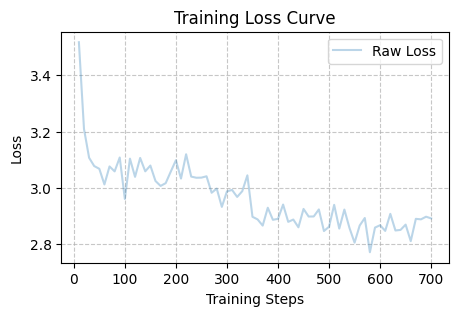

trainable params: 1179648 || all params: 125619456 || trainable: 0.94%
None


In [ ]:
lora_config = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=0.01,
    bias="none",
    task_type="CAUSAL_LM",
)

MODEL = reload_model()

# EXERCISE 20: Wrap our base model into the CustomPeftModel wrapper class
MODEL = CustomPeftModel(MODEL, lora_config)

# Use the Learning Rate the same as from Step 10 full LoRA Run
trainer = train(
    model=MODEL,
    lora_config=lora_config,
    learning_rate=LORA_LEARNING_RATE,
    num_epochs=2,
)
print(print_trainable_parameters(MODEL))

## Eval

In [ ]:
run_ft_evals()

0
Lightning happens when the negative charges (electrons) in the bottom of the cloud are attracted to the positive charges (protons) in the ground.
--------------
The lightning was a Category 0 lightning strike that occurred on January 21, 2002.
****************
1
• 1978 - the launch of the sculptural program that included the construction of seven contemporary fountains in Paris
• 1937 - fountains of the Palais de Chaillot were built
• 1971 - the date that Les Halles was torn down
--------------
Dates: Date:
Date:
Date:
Date:
Description:
****************
2
foot is imperial, metre is metric
--------------
The foot is an imperial measurement, and the metre is the length of a foot in meters. m is meters.
****************
3
Asperger syndrome (AS), or Asperger's, is a neurodevelopmental condition characterized by significant difficulties in social interaction and nonverbal communication, along with restricted and repetitive patterns of behavior and interests. The syndrome is no longer rec

# Other PEFT Techniques


1.   Quantization [doc](https://huggingface.co/docs/peft/en/developer_guides/quantization)
2.   Quantization + LoRA [doc](https://huggingface.co/blog/4bit-transformers-bitsandbytes)
3.   Soft prompt tuning [doc](https://huggingface.co/docs/peft/en/conceptual_guides/prompting)



# ✨ Resources used for this tutorial and references




1. [Huggingface LoRA](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora)
2.   [Huggingface Finetuning](https://huggingface.co/docs/transformers/en/training)
3. [LLM Optimizers](https://towardsdatascience.com/fine-tuning-llms-with-32-bit-8-bit-and-paged-adamw-optimizers-1034e3105634)
4. [LoRA Hypers](https://medium.com/@fartypantsham/what-rank-r-and-alpha-to-use-in-lora-in-llm-1b4f025fd133)
5. [M2Lschool Previous Tutorial](https://github.com/M2Lschool/tutorials2024/blob/main/1_nlp/part_III_llm_finetuning/LoRA.ipynb)